In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:

from dataclasses import replace
import itertools
from pathlib import Path
import pickle

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, cdist
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

from src.analysis.state_space import prepare_state_trajectory, StateSpaceAnalysisSpec
from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.models import get_best_checkpoint
from src.models.integrator import ContrastiveEmbeddingModel, compute_embeddings, load_or_compute_embeddings

In [5]:
model_dir = "outputs/models/w2v2_8/syllable"
# equiv_dataset_path = "../data/timit_equiv_phoneme_within_word_prefix_1.pkl"
model_dir = "out/ce_model_syllable_6_8"
equiv_dataset_path = "data/timit_equiv_phoneme_6_1.pkl"
output_dir = "."

state_space_spec_path = "out/state_space_specs/all_syllables.pkl"

metric = "cosine"

In [6]:
model = ContrastiveEmbeddingModel.from_pretrained(get_best_checkpoint(model_dir))
model.eval()

ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=8, bias=True)
  )
)

In [7]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = pickle.load(f)

In [8]:
with open(state_space_spec_path, "rb") as f:
    state_space_spec: StateSpaceAnalysisSpec = pickle.load(f)
assert state_space_spec.is_compatible_with(equiv_dataset)

In [9]:
model_representations = load_or_compute_embeddings(model, equiv_dataset, model_dir, equiv_dataset_path)

In [10]:
pca = PCA(n_components=2)
model_representations_pca = pca.fit_transform(model_representations)

In [50]:
# Retain only syllables with N or more instances
retain_n = 5
retain_idxs = [idx for idx, target_frames in enumerate(state_space_spec.target_frame_spans)
               if len(target_frames) >= retain_n]
state_space_spec = replace(state_space_spec,
    labels=[state_space_spec.labels[i] for i in retain_idxs],
    target_frame_spans=[state_space_spec.target_frame_spans[i] for i in retain_idxs],
)

In [51]:
spec_label_strs = ["".join(phones) for phones in state_space_spec.labels]

In [52]:
trajectory = prepare_state_trajectory(model_representations, state_space_spec)

In [53]:
len(trajectory)

1626

In [54]:
def get_mean_distance(samp1, samp2, metric=None):
    distances = cdist(samp1, samp2, metric=metric)
    distances = np.triu(distances, k=1)
    return distances[distances != 0].mean()

## Estimate within-syllable distance

In [55]:
max_num_instances = 50
within_distance = np.zeros((len(trajectory), trajectory[0].shape[1]))
for i, trajectory_i in enumerate(tqdm(trajectory)):
    within_distance_i = []
    num_instances, num_frames, num_dims = trajectory_i.shape

    num_instances_limited = min(num_instances, max_num_instances)
    samples_i = trajectory_i[np.random.choice(num_instances, size=num_instances_limited, replace=False)]
    for j in range(num_frames):
        within_distance[i, j] = get_mean_distance(samples_i[:, j, :], samples_i[:, j, :], metric=metric)

  0%|          | 0/1626 [00:00<?, ?it/s]

<Axes: >

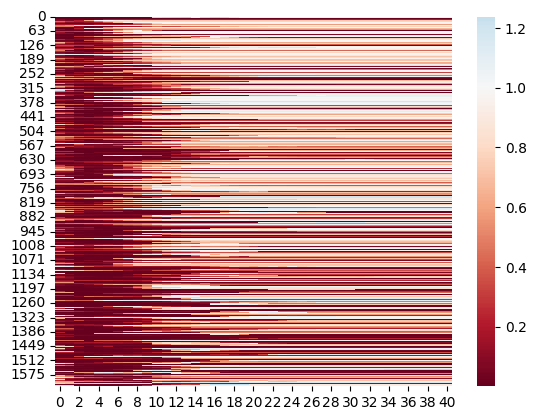

In [56]:
sns.heatmap(within_distance, center=1, cmap="RdBu")

In [57]:
within_distance_df = pd.DataFrame(within_distance, index=pd.Index(spec_label_strs, name="syllable")) \
    .reset_index() \
    .melt(id_vars=["syllable"], var_name="frame", value_name="distance")

<Axes: xlabel='frame', ylabel='distance'>

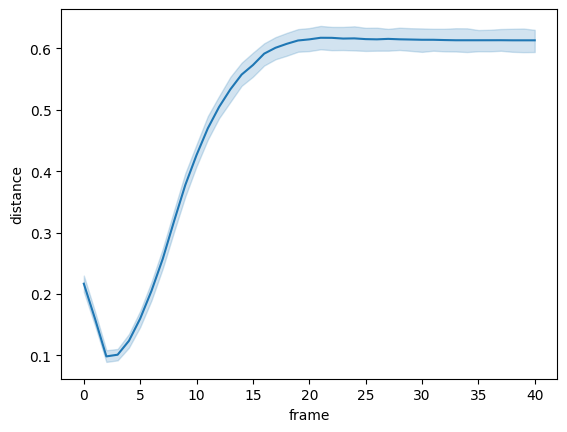

In [58]:
sns.lineplot(data=within_distance_df, x="frame", y="distance")

## Estimate between-syllable distance

In [ ]:
num_samples = min(len(trajectory) - 1, 50)
max_num_instances = 50
between_samples = [np.random.choice(list(range(idx)) + list(range(idx + 1, len(trajectory))),
                                    num_samples, replace=False)
                   for idx in range(len(trajectory))]
between_distances = np.zeros((len(trajectory), trajectory[0].shape[1], num_samples))
for i, between_samples_i in enumerate(tqdm(between_samples)):
    traj_i = trajectory[i]
    if traj_i.shape[0] > max_num_instances:
        traj_i = traj_i[np.random.choice(traj_i.shape[0], size=max_num_instances, replace=False)]
    
    for j, between_sample in enumerate(between_samples_i):
        traj_j = trajectory[between_sample]
        if traj_j.shape[0] > max_num_instances:
            traj_j = traj_j[np.random.choice(traj_j.shape[0], size=max_num_instances, replace=False)]
        
        for k in range(trajectory[0].shape[1]):
            between_distances[i, k, j] = get_mean_distance(traj_i[:, k, :], traj_j[:, k, :], metric=metric).mean()

  0%|          | 0/1626 [00:00<?, ?it/s]

In [ ]:
between_distances_df = pd.DataFrame(between_distances.mean(axis=-1),
                                    index=pd.Index(spec_label_strs, name="syllable")) \
    .reset_index() \
    .melt(id_vars=["syllable"], var_name="frame", value_name="distance")

In [ ]:
sns.lineplot(data=between_distances_df, x="frame", y="distance")

## Together

In [ ]:
merged_df = pd.concat([within_distance_df.assign(type="within"), between_distances_df.assign(type="between")])
merged_df.to_csv(Path(output_dir) / "distances.csv", index=False)
merged_df

In [ ]:
ax = sns.lineplot(data=merged_df, x="frame", y="distance", hue="type")
ax.set_title("Representational distance within- and between-syllable")
ax.set_xlabel("Frames since phoneme onset")
ax.set_ylabel(f"{metric.capitalize()} distance")

## RSA

In [ ]:
num_frames = trajectory[0].shape[1]

syllable_length = 2
all_syllables = sorted([label for label in state_space_spec.labels if len(label) == syllable_length])

# Prepare balanced sample of representations for each syllable in each category
num_instances = min(len(state_space_spec.target_frame_spans[state_space_spec.labels.index(syllable)])
                    for syllable in all_syllables)

syllable_representations = {}
for syllable in all_syllables:
    sample_instance_idxs = np.random.choice(len(state_space_spec.target_frame_spans[state_space_spec.labels.index(syllable)]),
                                            num_instances, replace=False)
    syllable_representations[syllable] = np.array([trajectory[state_space_spec.labels.index(syllable)][idx]
                                                   for idx in sample_instance_idxs])

# Compute between-phoneme distances
distances = np.zeros((len(all_syllables), len(all_syllables), trajectory[0].shape[1]))
for p1, p2 in tqdm(list(itertools.product(list(range(len(all_syllables))), repeat=2))):
    if p1 == p2:
        continue
    for k in range(num_frames):
        distances[p1, p2, k] = get_mean_distance(syllable_representations[all_syllables[p1]][:, k, :],
                                                 syllable_representations[all_syllables[p2]][:, k, :], metric=metric)

In [ ]:
all_syllable_labels = ["".join(phones) for phones in all_syllables]
sns.clustermap(pd.DataFrame(distances.mean(-1), index=all_syllable_labels, columns=all_syllable_labels),
               center=1, cmap="RdBu")